# Importing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Load the dataset
train_data = pd.read_csv('/train.csv')
test_data = pd.read_csv('/test.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cleaning

In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.split()
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    return " ".join(text)

train_data['cleaned_reviews'] = train_data['review'].apply(clean_text)
test_data['cleaned_reviews'] = test_data['review'].apply(clean_text)

train_data['sentiment_encoded'] = train_data['sentiment'].map({'pos': 1, 'neg': 0})
test_data['sentiment_encoded'] = test_data['sentiment'].map({'pos': 1, 'neg': 0})

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['cleaned_reviews'])

X_train = tokenizer.texts_to_sequences(train_data['cleaned_reviews'])
X_test = tokenizer.texts_to_sequences(test_data['cleaned_reviews'])

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

y_train = np.array(train_data['sentiment_encoded'])
y_test = np.array(test_data['sentiment_encoded'])

# Model

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - accuracy: 0.5114 - loss: 0.6929 - val_accuracy: 0.5811 - val_loss: 0.6887
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 593ms/step - accuracy: 0.6348 - loss: 0.6611 - val_accuracy: 0.7838 - val_loss: 0.4991
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 594ms/step - accuracy: 0.7611 - loss: 0.5546 - val_accuracy: 0.8341 - val_loss: 0.4300
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 640ms/step - accuracy: 0.7799 - loss: 0.5180 - val_accuracy: 0.8292 - val_loss: 0.4290
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 631ms/step - accuracy: 0.8114 - loss: 0.4768 - val_accuracy: 0.8534 - val_loss: 0.3891
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8501 - loss: 0.4146
Test Accuracy: 85.34%


In [21]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print individual metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate and print classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n", report)

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step
Precision: 0.8567
Recall: 0.8489
F1 Score: 0.8528
Test Accuracy: 85.34%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.85      0.86      0.85     12500
     Class 1       0.86      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



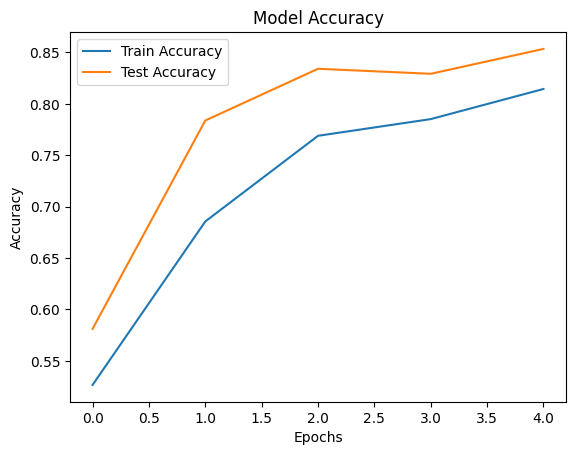

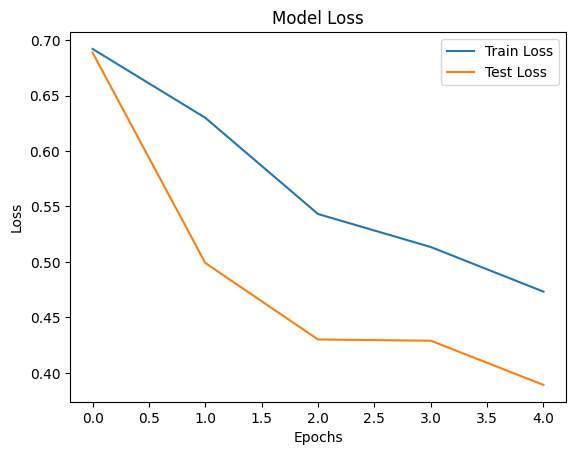

In [20]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

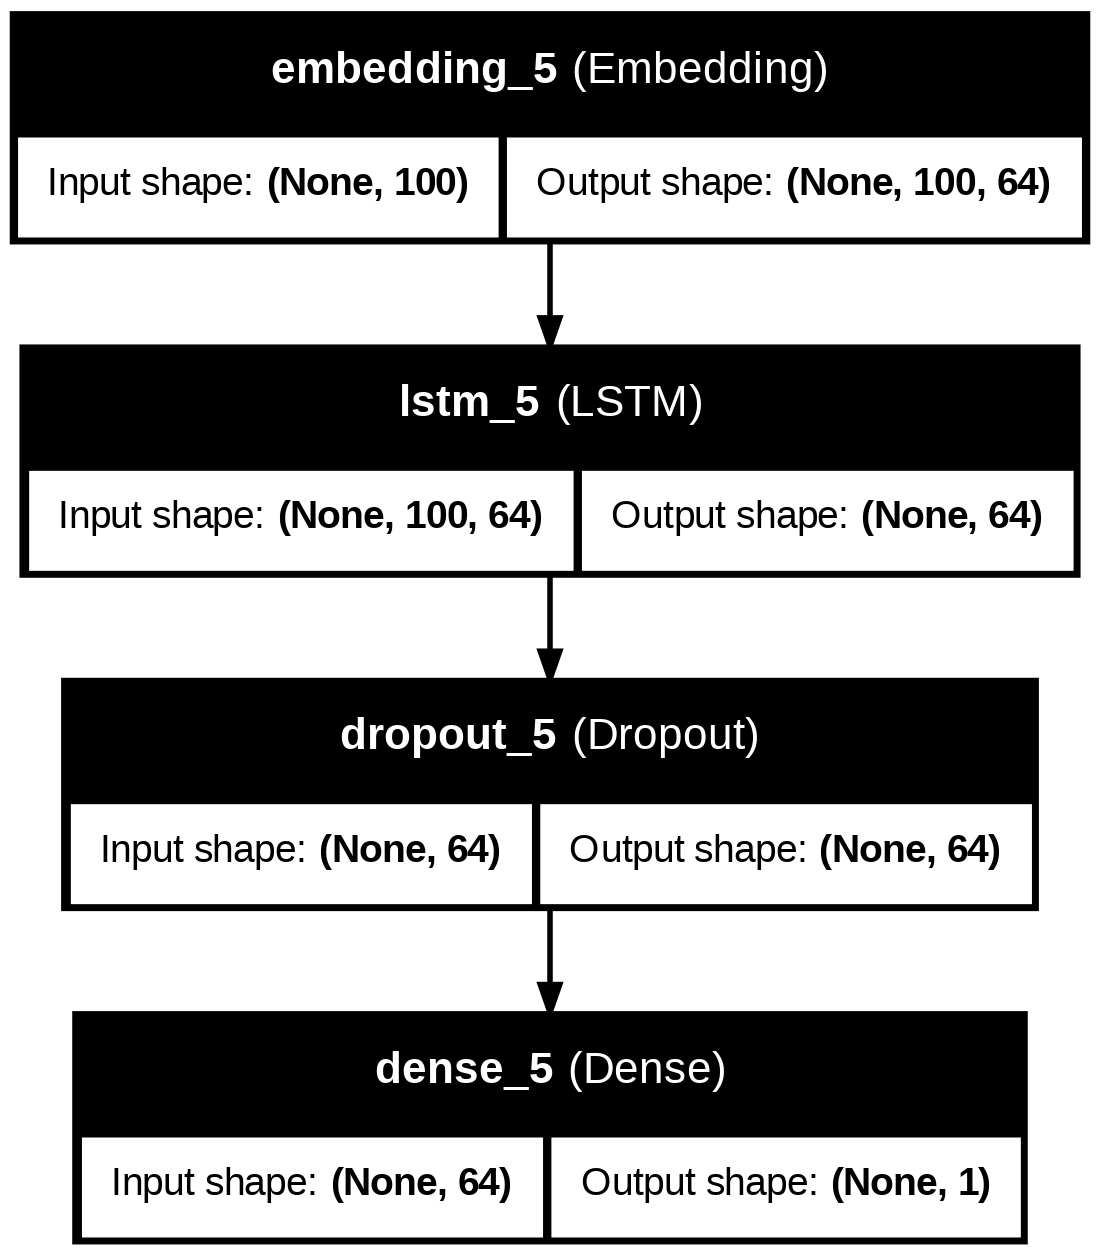

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Ablation Studies

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=4, batch_size=512, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5038 - loss: 0.6935 - val_accuracy: 0.5871 - val_loss: 0.6913
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5972 - loss: 0.6692 - val_accuracy: 0.8306 - val_loss: 0.4197
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7860 - loss: 0.5069 - val_accuracy: 0.8101 - val_loss: 0.4448
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8210 - loss: 0.4548 - val_accuracy: 0.8242 - val_loss: 0.4181
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7984 - loss: 0.4417
Test Accuracy: 82.42%


In [28]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print individual metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate and print classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n", report)

782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step
Precision: 0.8531
Recall: 0.7834
F1 Score: 0.8167
Test Accuracy: 82.42%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.87      0.83     12500
     Class 1       0.85      0.78      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



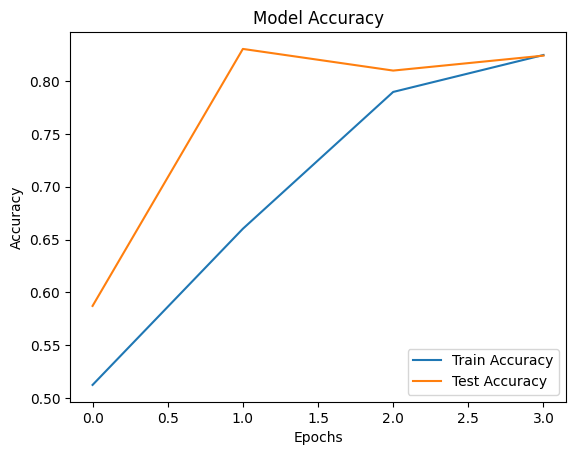

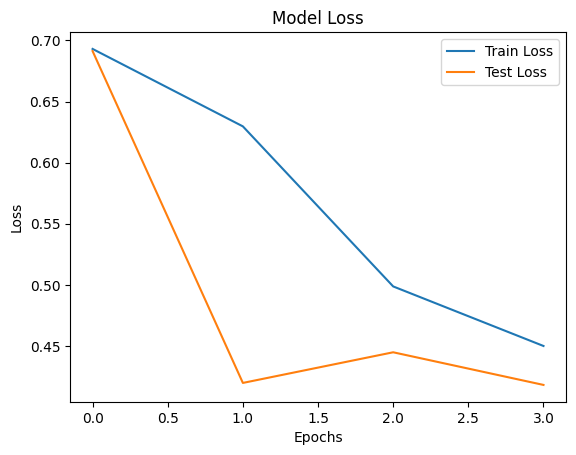

In [26]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

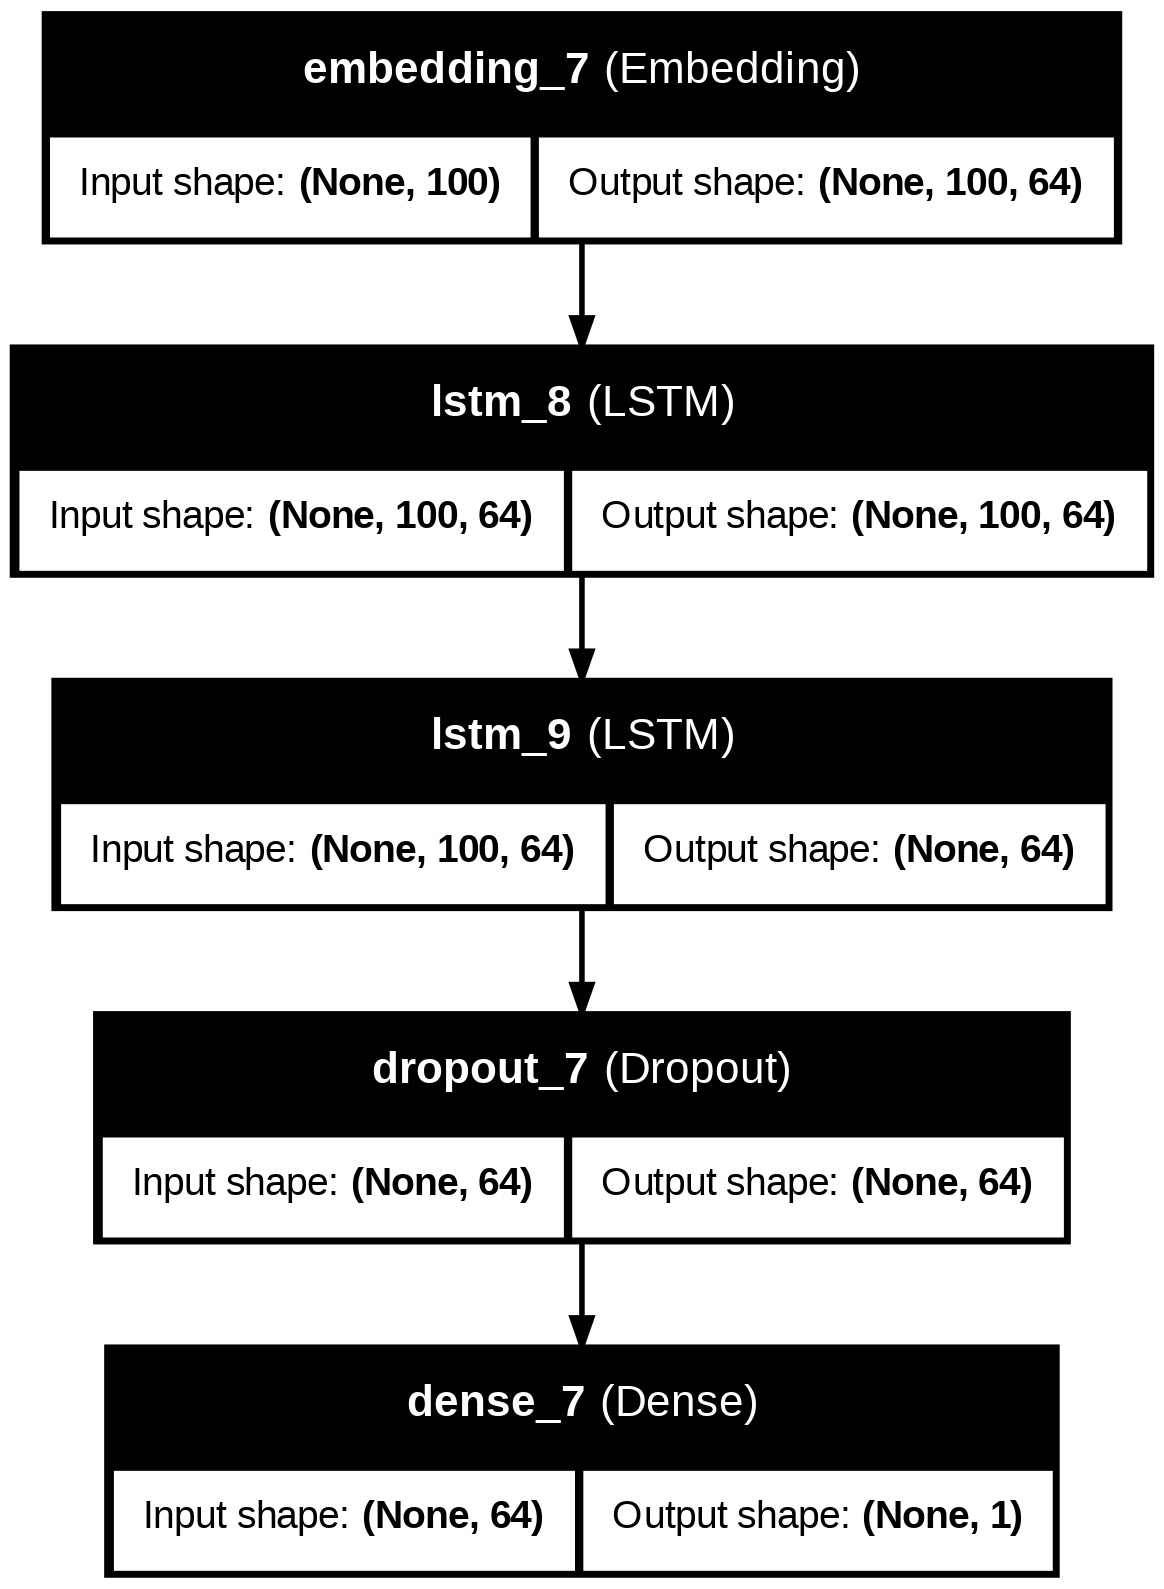

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True)